<h1>Round 3 (Introduced Bias)</h1>

Changes since the last analysis:

- Bandpass filtering at 11-16 Hz was performed AFTER the epochs were created. Specifically, the filtering was performed during the moving window stage of the process.
- Two separate starting conditions for spindles and non-spindles. For non-spindles, NLLS parameters initialised to 0.

In [2]:
# Importing initial libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing libraries for machine learning via sk-learn:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


<h2>Data Pre-Processing</h2>

In [5]:
df = pd.read_csv('third_round.csv')
df.head(10)

,a,b,c,d,e,f,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,0.527804,4.893096,-2.401058,2.483427e+06,-94.034062,8.893904,14.336918,2201.392070,2442.885499,239.349912,0.901144,0.097978,-14.965986,-1.043878,-2.367893,2.326263,0.978468,0.949751,0
1,-2.138058,-0.775656,-23.231398,2.536273e+07,-3.447090,25.445694,14.336918,0.155658,3340.112401,3340.266200,0.000047,1.000046,-0.548621,-0.038266,-9.065842,8.979945,3.655279,0.000530,0
2,-4.924472,3.994396,-19.380313,1.817975e+07,33.973295,-58.655407,15.360983,0.003054,916.628121,916.612111,0.000003,0.999983,5.407018,0.351997,-4.927009,5.082210,1.914797,0.007225,0
3,-0.665131,-5.405273,-18.372278,5.527986e+07,0.167347,0.000000,12.288786,0.199355,2977.612056,2977.808686,0.000067,1.000066,0.026634,0.002167,-7.961605,7.657919,3.451266,-0.023784,0
4,-0.912819,-0.146721,-0.072650,3.439822e+07,0.612192,0.000000,12.288786,1.167130,1864.917493,1866.686526,0.000626,1.000949,0.097433,0.007929,-7.064273,6.848352,2.732535,-0.005953,0
5,-0.841406,-0.186901,-0.874835,3.771226e+07,0.357225,0.000000,12.288786,1.677390,1277.712110,1279.370146,0.001313,1.001298,0.056854,0.004626,-5.321651,5.214795,2.262185,0.019504,0
6,-2.695292,2.713698,2.835527,1.791613e+07,-4.718531,7.184676,14.336918,0.236572,949.630349,949.741916,0.000249,1.000117,-0.750978,-0.052381,-4.904423,4.850121,1.949094,0.002655,0
7,-0.876379,0.876342,-3.131111,1.992761e+07,2.002802,0.986128,12.288786,6.903222,481.965269,482.715911,0.014323,1.001557,0.318756,0.025939,-3.659332,4.333760,1.389555,0.046249,0
8,-0.888687,-0.209273,0.313487,3.310457e+07,-0.182458,0.461203,14.336918,0.250367,819.086824,819.415447,0.000306,1.000401,-0.029039,-0.002025,-4.449648,4.387541,1.810431,-0.000460,0
9,0.682130,1.599523,-1.496862,-6.983131e+05,-87.520568,12.002179,13.312852,534.796144,573.134723,38.381732,0.933107,0.066968,-13.929331,-1.046307,-0.952669,0.813485,0.391825,0.965991,0


<h2>QPS Parameter Statistics</h2>

Separating the QPS parameters from the other features, we'll first get some preliminary statistics behind the QPS parameters that have been obtained from the modified dataset creation method.

In [6]:
# Get the column names for the QPS parameters:
qps_params = list(df.columns[0:6])
qps_params.append('label')

# Pull part of the dataframe with columns that satisfy 'qps_params':
df_qps = df[qps_params]
df_qps.head()

,a,b,c,d,e,f,label
0,0.527804,4.893096,-2.401058,2.483427e+06,-94.034062,8.893904,0
1,-2.138058,-0.775656,-23.231398,2.536273e+07,-3.447090,25.445694,0
2,-4.924472,3.994396,-19.380313,1.817975e+07,33.973295,-58.655407,0
3,-0.665131,-5.405273,-18.372278,5.527986e+07,0.167347,0.000000,0
4,-0.912819,-0.146721,-0.072650,3.439822e+07,0.612192,0.000000,0


To observe the resultant statistics for ONLY spindles, we need to pull all rows with a corresponding ```label``` of 1. We'll then get the preliminary statistics as well as boxplots that visually describe the distribution of the parameter values.

In [7]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_qps_spindles = df_qps[df_qps['label'] == 1].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_qps_spindles.iloc[:,0:6].describe()

,a,b,c,d,e,f
count,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000
mean,1.086083,1.581369,-14.439643,0.114518,82.646808,-2.602892
std,1.876865,10.192368,18.487856,2.257453,8.500366,16.755284
min,-50.000000,-57.040112,-233.971311,-21.469825,6.874588,-89.353211
25%,0.561852,-0.127437,-18.273879,-1.359763,77.468647,-11.622034
50%,1.257487,1.430519,-8.076896,0.116864,82.769155,-2.435255
75%,2.031765,2.959611,-3.568163,1.604562,87.762327,5.630403
max,3.798527,229.532816,16.478551,22.258222,158.097406,103.680217


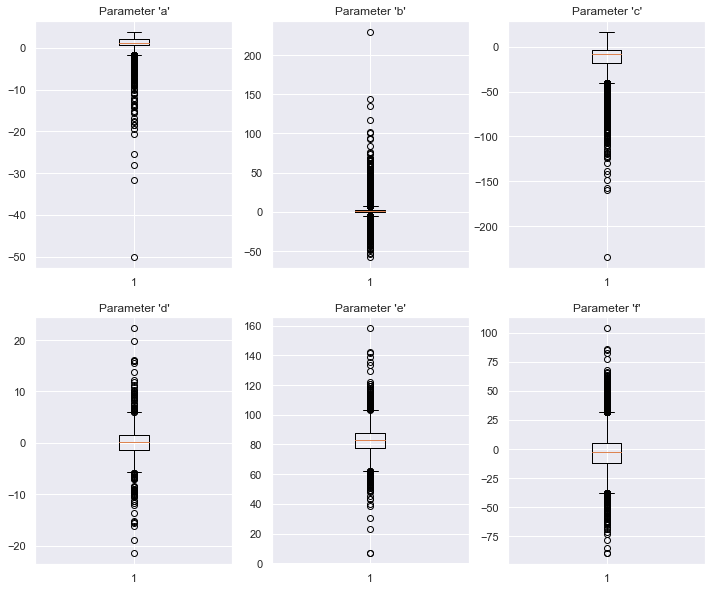

In [8]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(2,3,figsize=(12,10))
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].boxplot(df_qps_spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(df_qps_spindles.columns[k]))
        
        k = k + 1

As with the previous analysis, the boxplots show many outliers. This is to be expected as the windowing process is not exactly perfect and may not capture the spindle in a way that allows the NLLS to perform optimally. However, we know for sure that this method minimises any form of bias in the process. 

Because we are filtering in the 11-16 Hz for non-spindles as well, we should also see how the QPS parameter statistics for non-spindles compare to the spindles. We hope to see somewhat of a statistical difference between the spindles and non-spindles at least for parameters other than the angular carrier frequency, $e$.

In [10]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_qps_nonspindles = df_qps[df_qps['label'] == 0].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_qps_nonspindles.iloc[:,0:6].describe()

,a,b,c,d,e,f
count,503942.000000,503942.000000,503942.000000,5.039420e+05,503942.000000,503942.000000
mean,-1.945976,0.542461,-2.901775,2.902581e+07,-0.106803,0.015954
std,2.266141,7.624837,14.100116,2.225613e+07,16.736494,13.693109
min,-50.000000,-157.756797,-364.324109,-1.127343e+08,-262.722482,-262.493241
25%,-2.456130,-0.488650,-3.628986,1.205237e+07,-0.672527,-0.131148
50%,-1.040517,0.026658,-0.257011,3.153336e+07,0.000000,0.000000
75%,-0.895468,0.872665,1.381135,4.745033e+07,0.642779,0.155904
max,3.432205,293.429724,133.341067,7.718987e+07,225.427217,647.934608


At face-value, it seems the only parameter that exhibits a large statistics difference between the spindles and non-spindles is the amplitude parameter, $a$. All other frequencies seem to perturb around similar values for spindles and non-spindles. 

The only way to fully compare the spindles and non-spindles is to perform a two-sided T-Test between the spindles and non-spindles. We perform the T-Test below. We use the same null and alternative hypotheses as with the first test, specifically at a significance level of $\alpha = 1$. That is, for a significant statistical difference between the spindles and non-spindles, we preferably want a $p$-value from the t-test such as $p << \alpha$.

- Null Hypothesis ($H_0$): The mean QPS parameter value for spindles and non-spindles exhibit little to no statistical difference.
- Alternate Hypothesis ($H_A$): The mean QPS parameter value for spindles and non-spindles exhibit a significant statistical difference.

In [11]:
# Import independent T-Test function from the Scipy library.
from scipy.stats import ttest_ind

# The T-test relies on the lengths of both spindle and non-spindle datasets being equal. 
# For this T-test, we'll need to chop the non-spindle chunk to a length equal to the spindle dataset. 
# Before chopping, the rows need to be randomised to ensure bias is minimised.
df_qps_nonspindles = df_qps_nonspindles.sample(frac=1).iloc[0:len(df_qps_spindles), :]

# Perform the T-test for each column and get the p-values for each column. Use a for-loop to automate the process.
t_val = {}
p_val = {}
for col in df_qps.columns[0:6]:
    t_val[col], p_val[col] = ttest_ind(df_qps_spindles[col], df_qps_nonspindles[col])

In [12]:
p_val

{'a': 0.0,
 'b': 6.340881843951359e-09,
 'c': 0.0,
 'd': 0.0,
 'e': 0.0,
 'f': 1.2685189080152595e-20}

All parameters for spindles and non-spindles exhibit significant statistical difference! 

<h2>Other Parameter Statistics</h2>

In [13]:
# Get the column names for the QPS parameters:
other_params = list(df.columns[6:18])
other_params.append('label')

# Pull part of the dataframe with columns that satisfy 'qps_params':
df_other = df[other_params]
df_other.head()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,14.336918,2201.392070,2442.885499,239.349912,0.901144,0.097978,-14.965986,-1.043878,-2.367893,2.326263,0.978468,0.949751,0
1,14.336918,0.155658,3340.112401,3340.266200,0.000047,1.000046,-0.548621,-0.038266,-9.065842,8.979945,3.655279,0.000530,0
2,15.360983,0.003054,916.628121,916.612111,0.000003,0.999983,5.407018,0.351997,-4.927009,5.082210,1.914797,0.007225,0
3,12.288786,0.199355,2977.612056,2977.808686,0.000067,1.000066,0.026634,0.002167,-7.961605,7.657919,3.451266,-0.023784,0
4,12.288786,1.167130,1864.917493,1866.686526,0.000626,1.000949,0.097433,0.007929,-7.064273,6.848352,2.732535,-0.005953,0


In [14]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_other_spindles = df_other[df_other['label'] == 1].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_other_spindles.iloc[:,0:12].describe()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff
count,6539.000000,6.539000e+03,6539.000000,6539.000000,6.539000e+03,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000
mean,13.100334,5.335514e+03,6069.498999,733.991129,7.821954e-01,0.217805,13.153648,1.007665,-3.608521,3.604752,1.399523,0.877802
std,1.136707,9.335534e+03,9988.253415,1589.742622,1.692877e-01,0.169289,1.352875,0.102426,2.674455,2.655791,0.988660,0.108713
min,10.240655,2.700000e-16,47.653249,5.852367,1.030000e-20,0.002474,1.094125,0.071228,-35.742447,0.410145,0.153002,-0.240768
25%,12.288786,4.935395e+02,716.009973,147.667728,6.945313e-01,0.086341,12.329518,0.970616,-4.393603,1.951689,0.768551,0.833358
50%,13.312852,1.444455e+03,1885.093611,307.069236,8.215217e-01,0.178478,13.173120,1.001384,-2.857973,2.831524,1.108277,0.906463
75%,14.336918,5.460581e+03,6531.052052,757.006463,9.136594e-01,0.305469,13.967808,1.035034,-1.956562,4.383706,1.740122,0.955864
max,16.385049,1.077365e+05,112766.683400,59317.095000,9.975256e-01,1.000000,25.161984,1.960408,-0.390251,35.981347,15.403518,0.998762


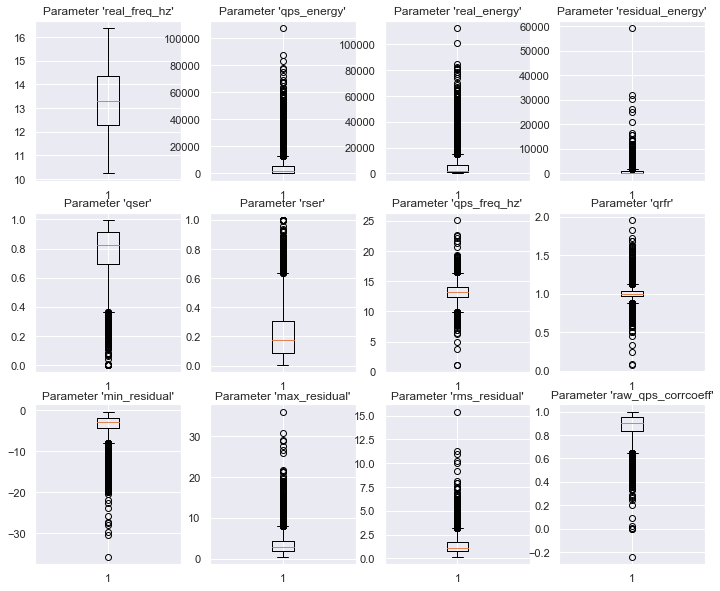

In [15]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(3,4,figsize=(12,10))
k = 0
for i in range(3):
    for j in range(4):
        ax[i,j].boxplot(df_other_spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(df_other_spindles.columns[k]))
        
        k = k + 1

In [16]:
# Pulling out ONLY spindle rows from the QPS dataframe:
df_other_nonspindles = df_other[df_other['label'] == 0].reset_index(drop=True)

# Getting rough statistics for each parameter.
df_other_nonspindles.iloc[:,0:12].describe()

,real_freq_hz,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff
count,503942.000000,5.039420e+05,503942.000000,503942.000000,5.039420e+05,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000
mean,13.019426,1.850692e+01,3417.350758,3403.430439,2.190936e-02,0.980615,-0.016998,-0.001302,-7.253149,7.209111,2.942942,0.046356
std,1.170315,2.229576e+02,6686.958371,6682.188692,1.110045e-01,0.111699,2.663696,0.205832,5.360886,5.288407,2.225494,0.139325
min,9.216590,5.920000e-23,25.926293,4.227916,2.340000e-25,0.002728,-41.813582,-3.402580,-140.711091,0.304922,0.130045,-0.208483
25%,12.288786,2.387846e-01,552.037855,539.511383,1.676357e-04,0.999273,-0.107036,-0.008281,-9.152621,3.651423,1.469029,-0.000560
50%,13.312852,1.401725e+00,1227.312265,1220.467940,8.885900e-04,1.000015,0.000000,0.000000,-5.553596,5.534253,2.209496,0.009140
75%,14.336918,5.784133e+00,3387.899479,3381.884192,3.391577e-03,1.000689,0.102301,0.007918,-3.657742,9.104999,3.677980,0.036586
max,17.409114,7.329698e+04,683205.829500,683212.439000,1.516544e+00,1.258048,35.877856,2.998124,-0.316415,137.132225,52.276666,0.998636


In [18]:
# Import independent T-Test function from the Scipy library.
from scipy.stats import ttest_ind

# The T-test relies on the lengths of both spindle and non-spindle datasets being equal. 
# For this T-test, we'll need to chop the non-spindle chunk to a length equal to the spindle dataset. 
# Before chopping, the rows need to be randomised to ensure bias is minimised.
df_other_nonspindles = df_other_nonspindles.sample(frac=1).iloc[0:len(df_other_spindles), :]

# Perform the T-test for each column and get the p-values for each column. Use a for-loop to automate the process.
t_val_other = {}
p_val_other = {}
for col in df_other.columns[0:12]:
    t_val_other[col], p_val_other[col] = ttest_ind(df_other_spindles[col], df_other_nonspindles[col])

p_val_other

{'real_freq_hz': 0.009959762189368313,
 'qps_energy': 0.0,
 'real_energy': 2.144243581259399e-72,
 'residual_energy': 7.343633727290061e-247,
 'qser': 0.0,
 'rser': 0.0,
 'qps_freq_hz': 0.0,
 'qrfr': 0.0,
 'min_residual': 0.0,
 'max_residual': 0.0,
 'rms_residual': 0.0,
 'raw_qps_corrcoeff': 0.0}

In [19]:
# Begin by taking the original dataframe, 'df' and splitting it into spindles and non-spindles.
# Ensure, non-spindles have the same length as the spindle subset and shuffle rows to ensure randomisation.
spindles = df[df['label'] == 1].reset_index(drop=True)
non_spindles = df[df['label'] == 0].sample(frac=1).iloc[0:len(spindles), :].reset_index(drop=True)

# Join both spindle and non-spindle data subsets together. Shuffle the rows after concatenation
all_features = pd.concat([spindles, non_spindles], axis=0)
all_features = all_features.sample(frac=1).reset_index(drop=True)

<h2>Scatter Plot Of Features</h2>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


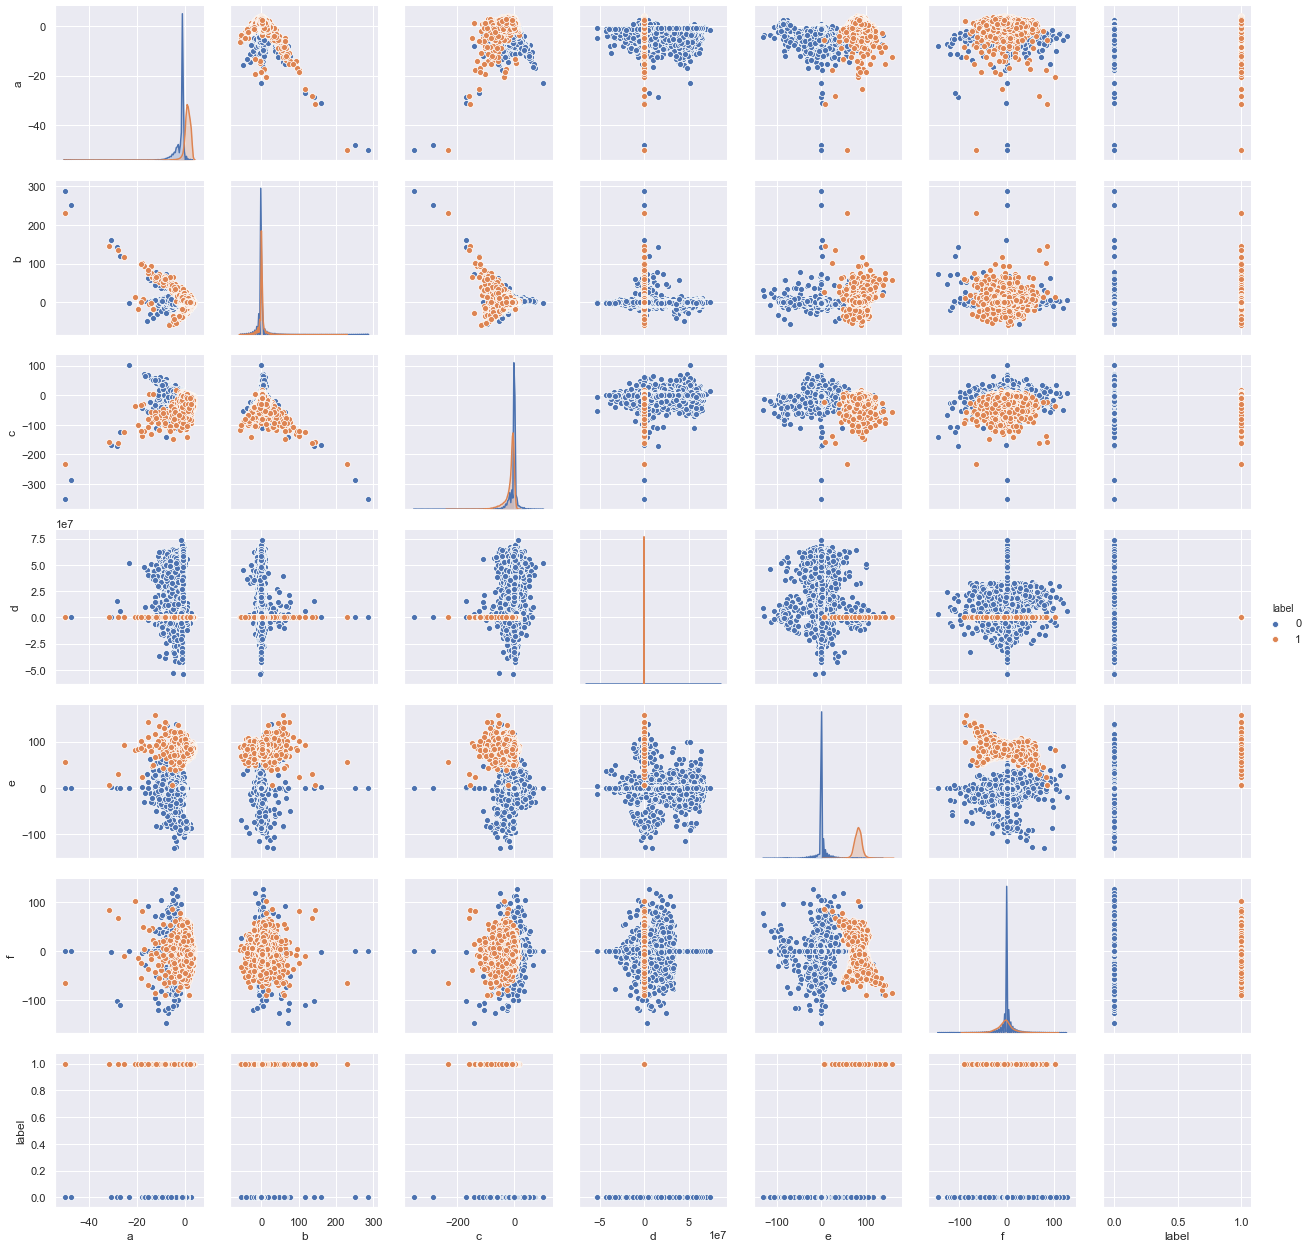

In [20]:
features = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
to_plot = all_features[features].copy()
g = sns.pairplot(to_plot, hue='label')

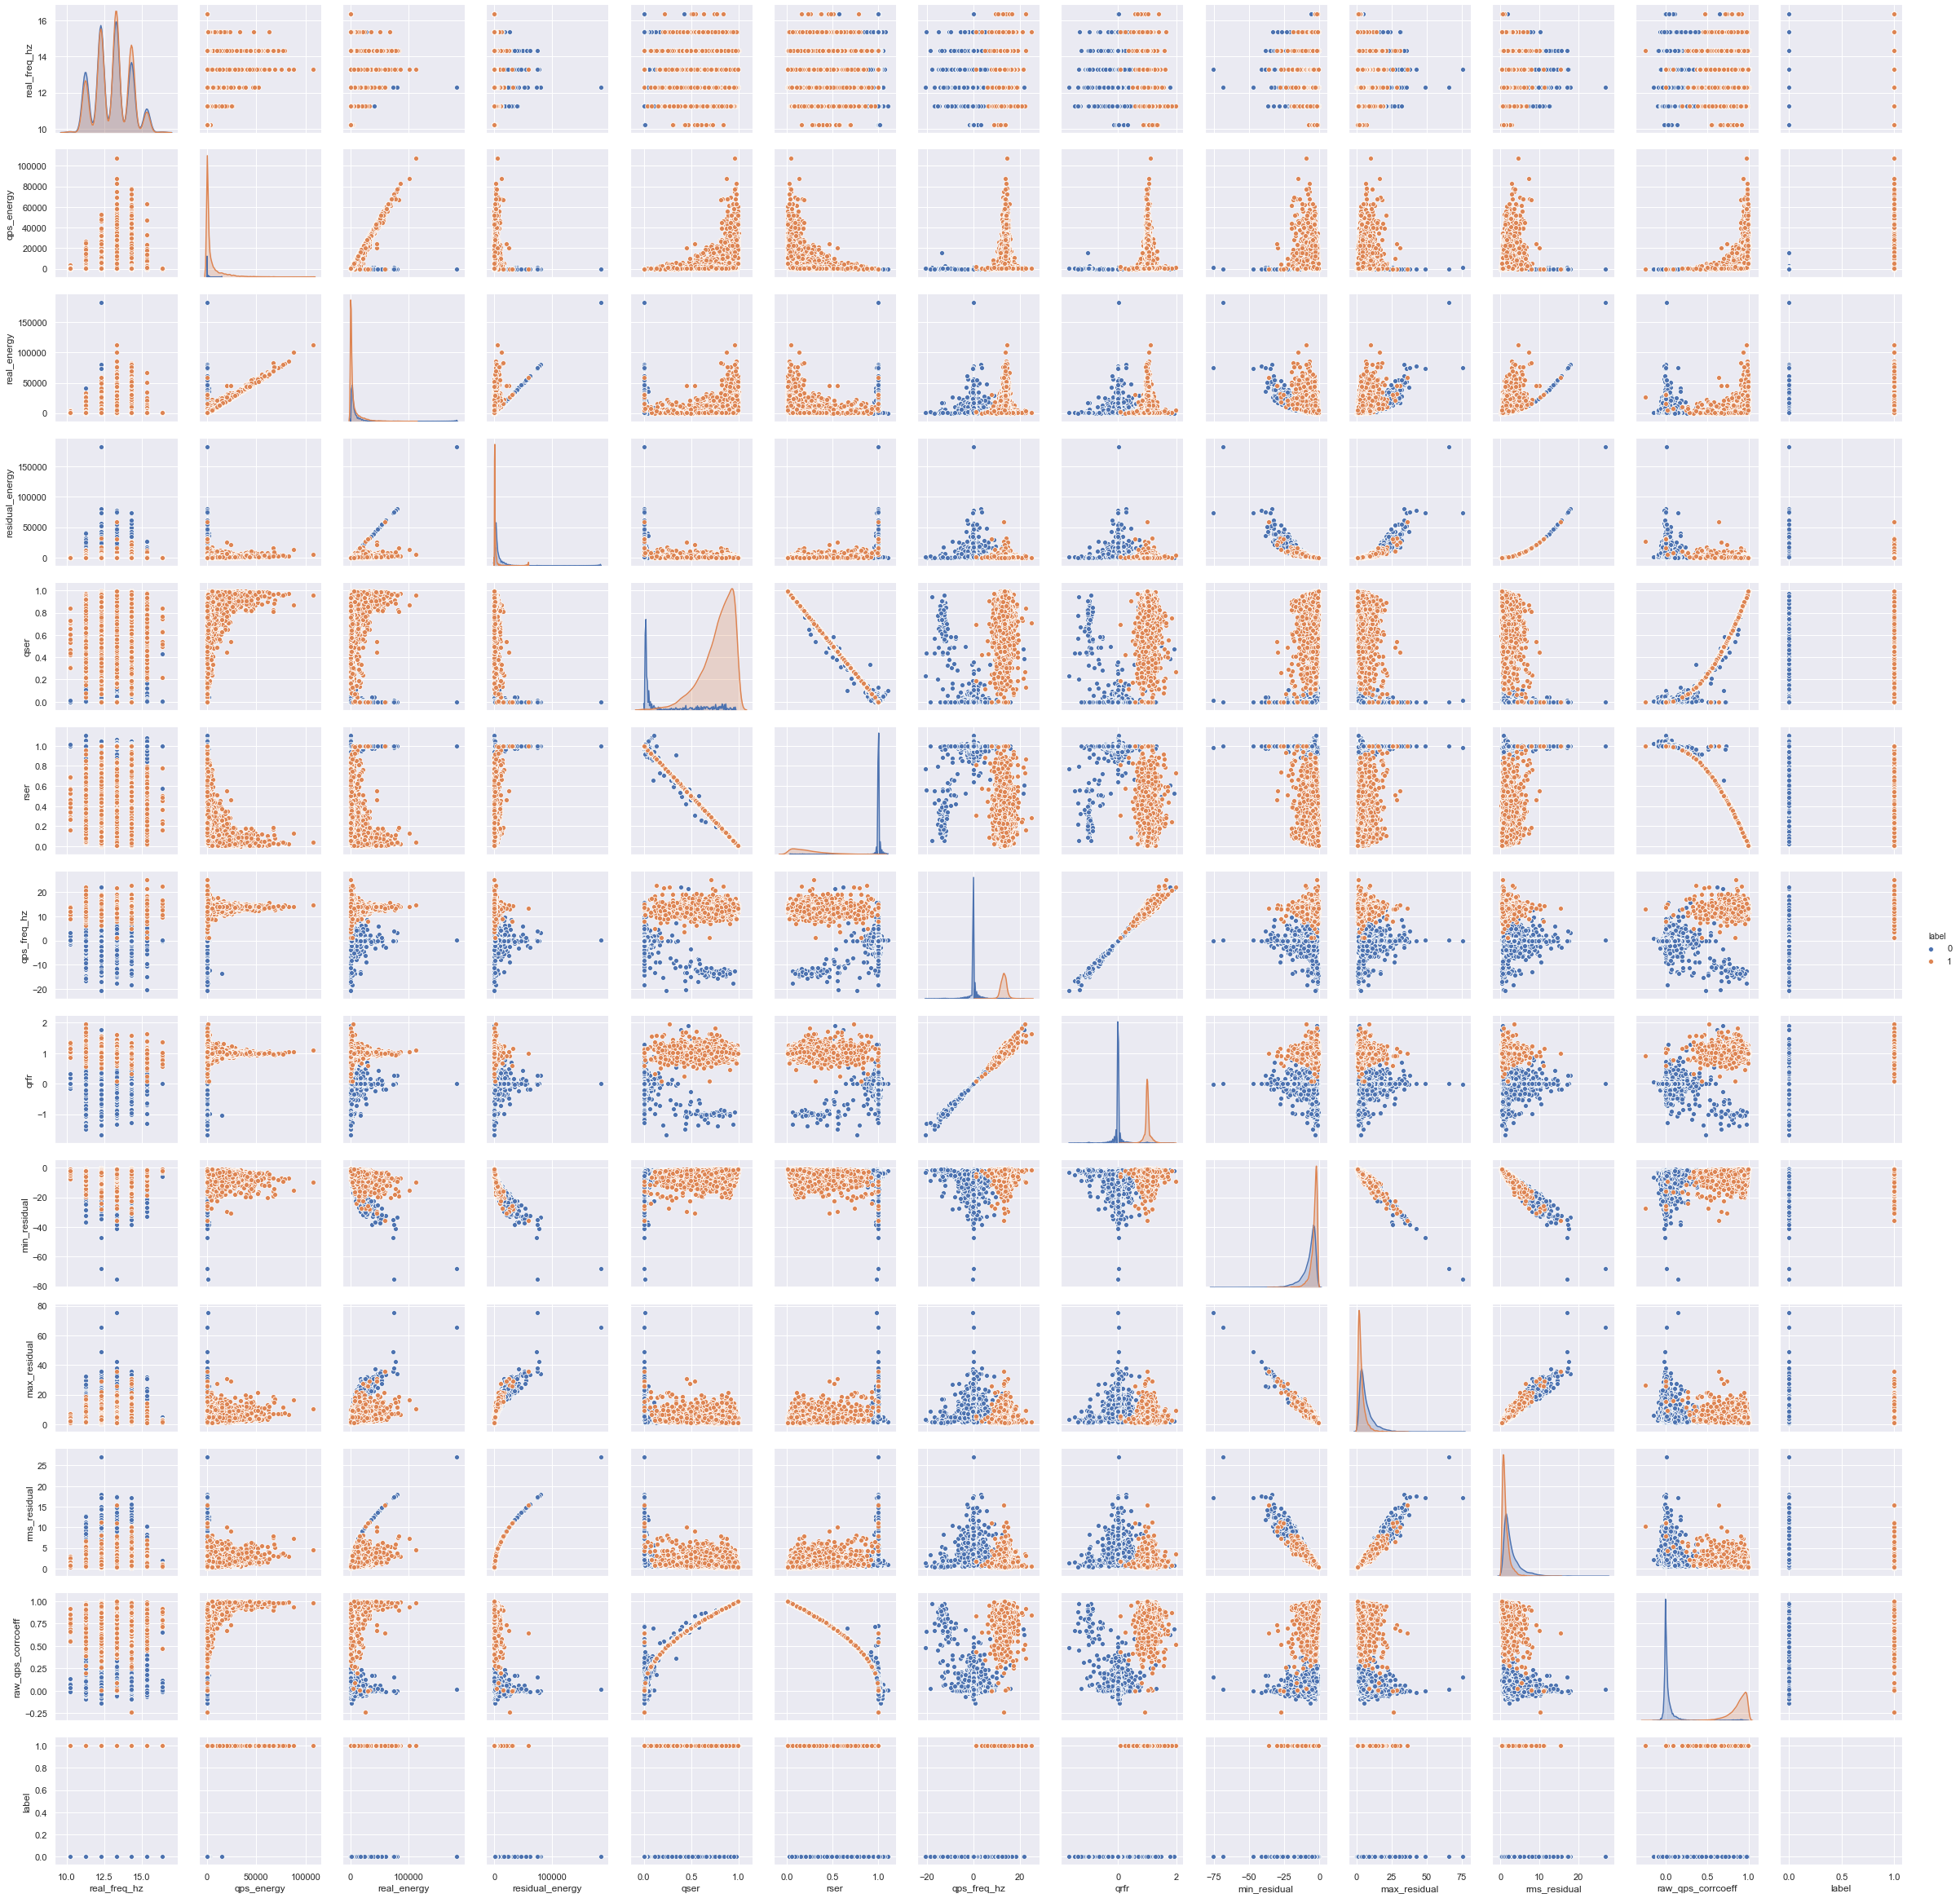

In [21]:
features = df_other.columns[0:13]
to_plot = all_features[features].copy()
g = sns.pairplot(to_plot, hue='label')

<h2>Scenario 1: Classification Using ALL Features</h2>

<h3>Using A <i>Support Vector Machine (SVM)</i></h3>

In [22]:
X = all_features.iloc[:, 0:18]
y = all_features.iloc[:,18]

# Split the 'all_features' dataframe into training and test subsets. CV is performed using 'cross_val_score'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Instantiate an empty SVM model
model = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

# Evaluate the accuracy score by cross-validation:
acc_scores_cv = cross_val_score(model, X_train, y_train, cv=5)

print("List Of Accuracies For Each Fold = {}".format(acc_scores_cv))
print("Average Accuracy = {}%".format(round(np.mean(acc_scores_cv), 3)))

List Of Accuracies For Each Fold = [0.99044434 0.99235547 0.98805542 0.99330784 0.9928264 ]
Average Accuracy = 0.991%


<h3>Using A Neural Network</h3>

Perhaps an ANN might yield better (or just <i>different</i> results) from using a quic algorithm like an SVM. The procedure to preparing an ANN is performed below.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8369 samples, validate on 2093 samples
Epoch 1/500
8369/8369 [==============================] - 1s 61us/step - loss: 0.1271 - acc: 0.9614 - val_loss: 0.0387 - val_acc: 0.9909
Epoch 2/500
8369/8369 [==============================] - 0s 30us/step - loss: 0.0395 - acc: 0.9912 - val_loss: 0.0354 - val_acc: 0.9914
Epoch 3/500
8369/8369 [==============================] - 0s 25us/step - loss: 0.0366 - acc: 0.9910 - val_loss: 0.0435 - val_acc: 0.9895
Epoch 00003: early stopping
Train: 0.991, Test: 0.992


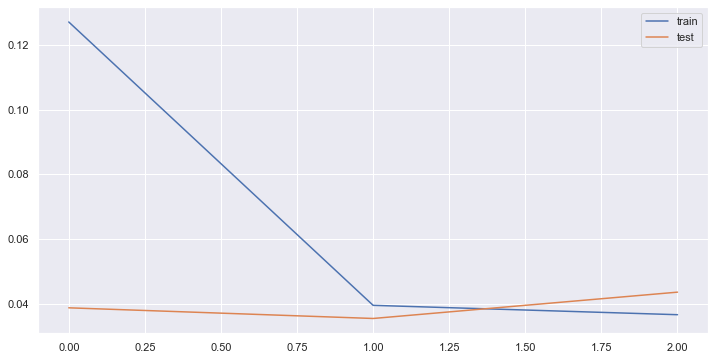

In [23]:
model_nn = Sequential()
model_nn.add(Dense(38, activation='relu', input_dim=18))
model_nn.add(Dense(38, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model_nn.fit(X_train, y_train, validation_split=0.2, epochs=500, callbacks=[es])

# evaluate the model
_, train_acc = model_nn.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_nn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()